In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
#==================================================================
#                    INSTALLING DEPENDENCIES
#==================================================================

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa as lb
import librosa.display
import IPython.display as ipd
import os
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')



Axes(0.125,0.11;0.775x0.77)


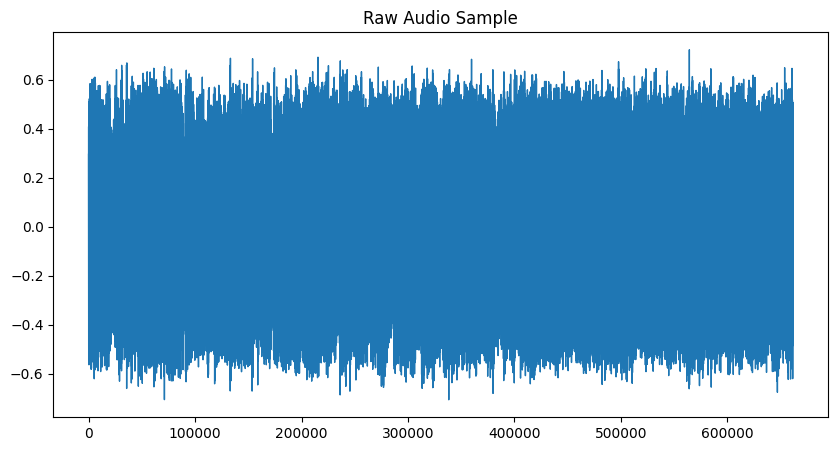

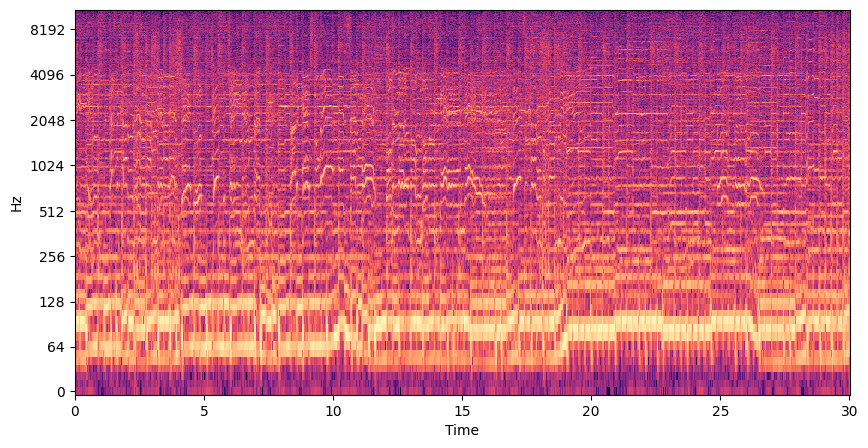

In [35]:
audio_files = glob.glob(r"/content/drive/MyDrive/ColabNotebooks/Dataset/Data/genres_original/*/*.wav")#(r'C:\Datasets\Data\genres_original\*\*.wav')

y, sr = librosa.load(audio_files[0])

print(pd.Series(y).plot(figsize=(10, 5), lw = 1, title = "Raw Audio Sample"))
D = librosa.stft(y)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
S_db.shape

fig, ax = plt.subplots(figsize=(10, 5))
img = librosa.display.specshow(S_db, x_axis="time", y_axis="log", ax=ax)

In [36]:
#-------------------------------------------------------------------
#                       ENHANCED FEATURE EXTRACTION
#-------------------------------------------------------------------

def extract_enhanced_features(file_path, n_mels=128, duration=30, n_fft=2048, hop_length=512):
    """Extract enhanced mel spectrogram with data augmentation capabilities"""
    try:
        # Load audio with better parameters
        y, sr = librosa.load(file_path, duration=duration, sr=22050, mono=True)

        if len(y) == 0:
            print(f"Warning: Empty audio file {file_path}")
            return None

        # Normalize audio
        y = librosa.util.normalize(y)

        # Extract mel spectrogram with better parameters
        S = librosa.feature.melspectrogram(
            y=y,
            sr=sr,
            n_mels=n_mels,
            n_fft=n_fft,
            hop_length=hop_length,
            fmin=0,
            fmax=sr//2
        )

        # Convert to dB scale
        S_DB = librosa.power_to_db(S, ref=np.max)

        # Normalize to [-1, 1] range
        S_DB = (S_DB - S_DB.min()) / (S_DB.max() - S_DB.min()) * 2 - 1

        return S_DB

    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

def augment_audio(y, sr):
    """Apply data augmentation techniques"""
    augmented = []

    # Original
    augmented.append(y)

    # Time stretching
    y_stretch = librosa.effects.time_stretch(y, rate=0.9)
    if len(y_stretch) >= len(y):
        augmented.append(y_stretch[:len(y)])

    # Pitch shifting
    y_pitch = librosa.effects.pitch_shift(y, sr=sr, n_steps=2)
    augmented.append(y_pitch)

    # Add noise
    noise = np.random.normal(0, 0.005, len(y))
    y_noise = y + noise
    augmented.append(y_noise)

    return augmented

def load_dataset_enhanced(base_path, use_augmentation=True, test_mode=False):
    """Load dataset with enhanced features and optional augmentation"""
    genres = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]
    X, y = [], []
    skipped_files = []

    for genre in genres:
        folder = os.path.join(base_path, genre)
        print(f"Processing {genre}...")

        if not os.path.exists(folder):
            print(f"Folder {folder} does not exist!")
            continue

        file_count = 0
        files = [f for f in os.listdir(folder) if f.endswith(".wav")]

        # Limit files for testing
        if test_mode:
            files = files[:10]  # Only first 10 files per genre for testing

        for filename in files:
            filepath = os.path.join(folder, filename)

            if use_augmentation:
                # Load original audio for augmentation
                try:
                    y_audio, sr = librosa.load(filepath, duration=30, sr=22050, mono=True)
                    augmented_audios = augment_audio(y_audio, sr)

                    for aug_audio in augmented_audios:
                        # Create mel spectrogram from augmented audio
                        S = librosa.feature.melspectrogram(
                            y=aug_audio, sr=sr, n_mels=128, n_fft=2048, hop_length=512
                        )
                        S_DB = librosa.power_to_db(S, ref=np.max)
                        S_DB = (S_DB - S_DB.min()) / (S_DB.max() - S_DB.min()) * 2 - 1

                        if S_DB.shape[1] >= 660:
                            S_DB = S_DB[:, :660]
                            X.append(S_DB)
                            y.append(genre)
                            file_count += 1

                except Exception as e:
                    print(f"Error with augmentation for {filepath}: {e}")
                    # Fall back to normal extraction
                    mel = extract_enhanced_features(filepath)
                    if mel is not None and mel.shape[1] >= 660:
                        mel = mel[:, :660]
                        X.append(mel)
                        y.append(genre)
                        file_count += 1
            else:
                # Normal extraction without augmentation
                mel = extract_enhanced_features(filepath)
                if mel is not None and mel.shape[1] >= 660:
                    mel = mel[:, :660]
                    X.append(mel)
                    y.append(genre)
                    file_count += 1
                else:
                    skipped_files.append(filepath)

        print(f"Loaded {file_count} samples from {genre}")

    if skipped_files:
        print(f"\nSkipped {len(skipped_files)} problematic files")

    # Convert to numpy arrays
    X = np.array(X)
    X = X[..., np.newaxis]  # Shape: (samples, 128, 660, 1)

    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    y_cat = to_categorical(y_encoded)

    print(f"\nDataset loaded successfully!")
    print(f"Total samples: {len(X)}")
    print(f"Input shape: {X.shape}")
    print(f"Output shape: {y_cat.shape}")

    return X, y_cat, label_encoder



In [37]:
#=============================================================================
#                               ENHANCED CNN MODEL
#=============================================================================

def create_enhanced_model(input_shape=(128, 660, 1), num_classes=10):
    """Create an enhanced CNN model with better architecture"""

    model = Sequential([
        # First Conv Block
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Second Conv Block
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Third Conv Block
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Fourth Conv Block
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Dense Layers
        Flatten(),
        Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.5),

        Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.5),

        Dense(num_classes, activation='softmax')
    ])

    return model



In [38]:
#=================================================================
#                      TRAINING SETUP WITH CALLBACKS
#=================================================================

def train_model_enhanced(X_train, y_train, X_test, y_test, label_encoder):
    """Train the model with enhanced callbacks and monitoring"""

    # Create model
    model = create_enhanced_model()

    # Compile with better optimizer settings
    optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy', 'precision']
    )

    # Enhanced callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_accuracy',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            verbose=1
        ),
        ModelCheckpoint(
            #'best_music_model.h5',
            'best_music_model.keras',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        )
    ]

    print("Model Summary:")
    model.summary()

    # Train with callbacks
    print("\nStarting enhanced training...")
    history = model.fit(
        X_train, y_train,
        epochs=50,  # Increased epochs with early stopping
        batch_size=32,
        validation_data=(X_test, y_test),
        callbacks=callbacks,
        verbose=1
    )

    return model, history



In [39]:
#=================================================================
#                      EVALUATION AND VISUALIZATION
#=================================================================

def evaluate_model(model, X_test, y_test, label_encoder, history):
    """Comprehensive model evaluation"""

    # Predictions
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true_classes, y_pred_classes,
                              target_names=label_encoder.classes_))

    # Confusion matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Training history
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Final accuracy
    test_accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
    print(f"\nFinal Test Accuracy: {test_accuracy:.4f}")

    return test_accuracy



Loading dataset...
Processing blues...
Loaded 400 samples from blues
Processing classical...
Loaded 400 samples from classical
Processing country...
Loaded 400 samples from country
Processing disco...
Loaded 400 samples from disco
Processing hiphop...
Loaded 400 samples from hiphop
Processing jazz...
Loaded 396 samples from jazz
Processing metal...
Loaded 400 samples from metal
Processing pop...
Loaded 400 samples from pop
Processing reggae...
Loaded 400 samples from reggae
Processing rock...
Loaded 400 samples from rock

Dataset loaded successfully!
Total samples: 3996
Input shape: (3996, 128, 660, 1)
Output shape: (3996, 10)

Training set: (3196, 128, 660, 1)
Test set: (800, 128, 660, 1)
Classes: ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']
Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 660, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 660, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 660, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 330, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 330, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 330, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 330, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 330, 64)    │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 165, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 165, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 165, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 165, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 165, 128)   │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 82, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 82, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 82, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 82, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 41, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8, 41, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 83968)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    42,992,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 43,712,618 (166.75 MB)

 Trainable params: 43,710,122 (166.74 MB)

 Non-trainable params: 2,496 (9.75 KB)


Starting enhanced training...
Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 533ms/step - accuracy: 0.2340 - loss: 4.9479 - precision: 0.2963
Epoch 1: val_accuracy improved from -inf to 0.10000, saving model to best_music_model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 124s 870ms/step - accuracy: 0.2344 - loss: 4.9490 - precision: 0.2967 - val_accuracy: 0.1000 - val_loss: 20.4461 - val_precision: 0.1000 - learning_rate: 0.0010
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.3657 - loss: 4.9212 - precision: 0.4371
Epoch 2: val_accuracy did not improve from 0.10000
100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 282ms/step - accuracy: 0.3658 - loss: 4.9197 - precision: 0.4373 - val_accuracy: 0.1000 - val_loss: 11.5689 - val_precision: 0.1000 - learning_rate: 0.0010
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.4580 - loss: 4.2257 - precision: 0.5684
Epoch 3: val_accuracy did not improve from 0.10000
100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 271ms/step - accuracy: 0.4581 - loss: 4

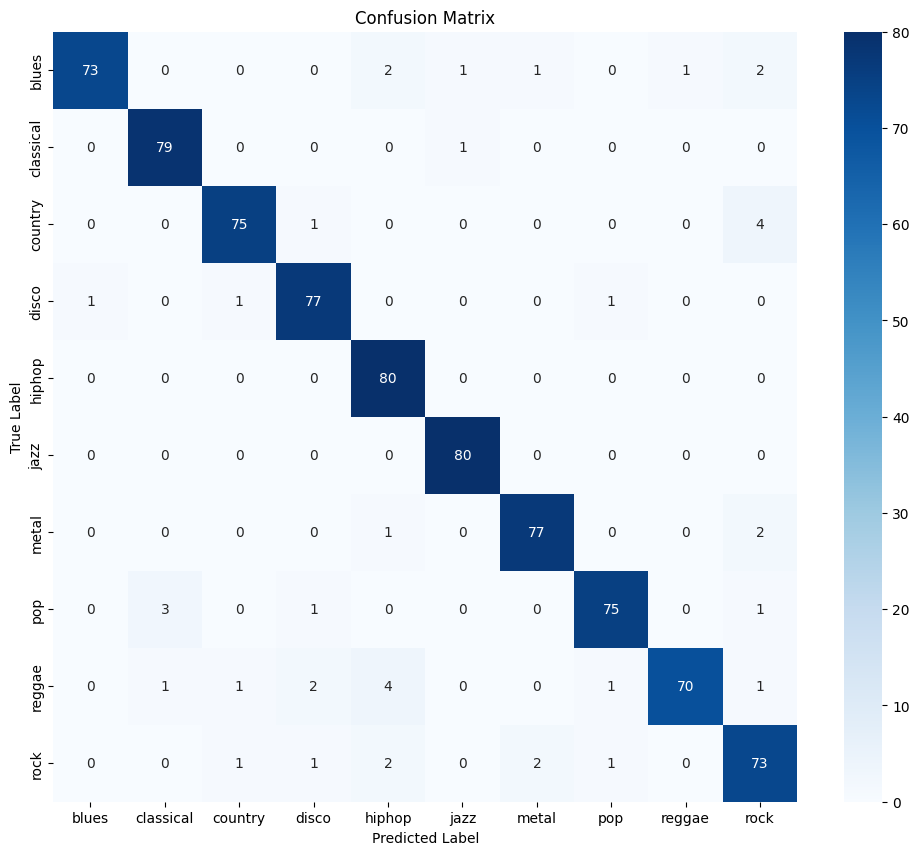

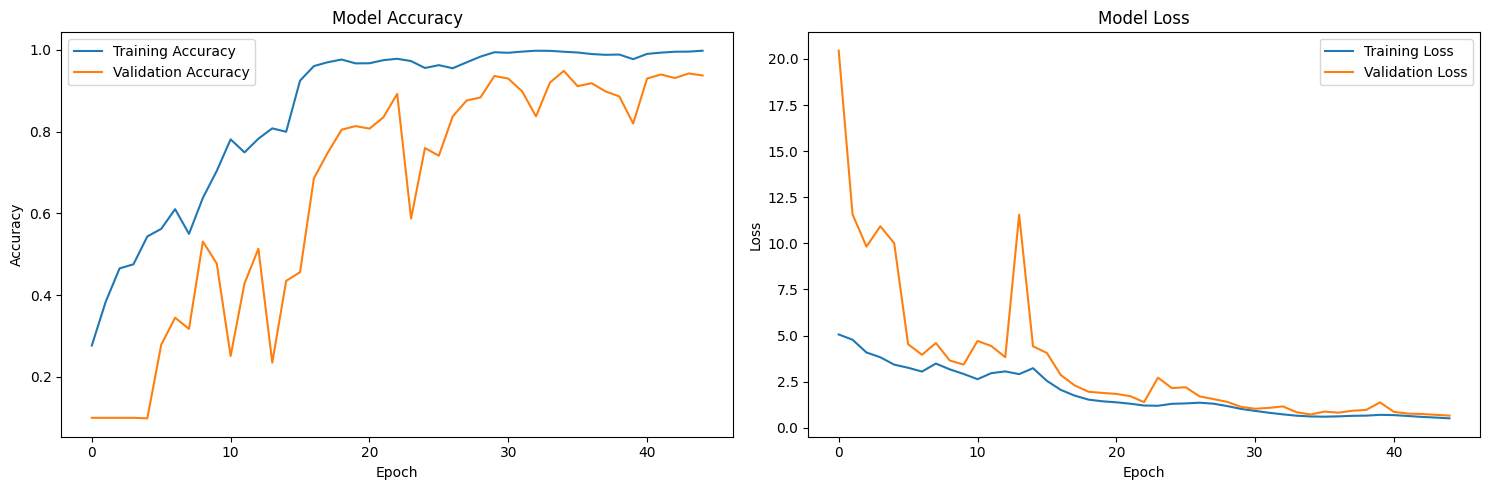


Final Test Accuracy: 0.9488

Training completed!
Final accuracy: 0.9488


In [10]:
#=================================================================
#                      MAIN EXECUTION
#=================================================================

def main():
    """Main execution function"""

    # Set random seeds for reproducibility
    np.random.seed(42)
    tf.random.set_seed(42)

    # Load dataset
    base_path = r"/content/drive/MyDrive/ColabNotebooks/Dataset/Data/genres_original"

    # For testing, use smaller dataset
    print("Loading dataset...")
    X, y, label_encoder = load_dataset_enhanced(base_path, use_augmentation=True, test_mode=False)

    # Split data with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=np.argmax(y, axis=1)
    )

    print(f"\nTraining set: {X_train.shape}")
    print(f"Test set: {X_test.shape}")
    print(f"Classes: {label_encoder.classes_}")

    # Train model
    model, history = train_model_enhanced(X_train, y_train, X_test, y_test, label_encoder)

    # Evaluate model
    accuracy = evaluate_model(model, X_test, y_test, label_encoder, history)

    print(f"\nTraining completed!")
    print(f"Final accuracy: {accuracy:.4f}")

    return model, history, label_encoder

# Run the enhanced training
if __name__ == "__main__":
    model, history, label_encoder = main()

In [40]:
model.save("enhanced_model.keras")